# SETUP



In [0]:
#general & Preprocessing imports
import os
import numpy as np
from scipy.sparse import csc_matrix, save_npz, load_npz
import re
import pickle
import pandas as pd
from datetime import datetime
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from nltk.stem import PorterStemmer, SnowballStemmer
nltk.download('stopwords')
stopword_list = stopwords.words('english')
import codecs
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Reshape, MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreasabia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
os.chdir('/Users/andreasabia/Documents/ESCP/NLP/project')
df=pd.read_csv('./export-forums_en.format.csv')

# DATA PREPARATION

In [0]:
answer=df[df['type']=='A']
question=df[df['type']=='Q']
comment=df[df['type']=='C']
comment=comment[['parent_id','content']]
question=question[['id','content','num_answers','date']]
answer=answer[['id','parent_id','content','date','author_crc','is_best_answer','votes']]

In [0]:
comment=comment.applymap(str)
comment=comment.groupby('parent_id').agg({'content': lambda x: ' '.join(x)})

In [0]:
corpus=pd.merge(left=answer, right=question, how='left', left_on='parent_id',
                right_on='id')

In [0]:
comment.index=comment.index.astype(int)

In [0]:
corpus=pd.merge(left=corpus, right=comment, how='left', left_on='id_x', right_index=True)

In [0]:
corpus['time']=corpus['date_x']-corpus['date_y']

In [0]:
test=corpus[['author_crc','is_best_answer']]

ans=test.groupby('author_crc').sum()
ans=ans.reset_index()

cou=test.groupby('author_crc').count()
cou=cou.reset_index()
test=pd.merge(left=ans, right=cou, how='inner', on='author_crc')
test['ratio']=test['is_best_answer_y']/test['is_best_answer_x']
test=test.replace([np.inf, -np.inf], 0)

test['ranking']=0
test['ratio']=test['ratio'].astype(float)

for i in range(len(test['ranking'])):
    if test['ratio'][i]<0.05:
        test['ranking'][i]=1
    elif test['ratio'][i]<4:
        test['ranking'][i]=2
    else:
        test['ranking'][i]=3

test=test[['author_crc','ranking']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
target=corpus['is_best_answer']
A=corpus['content_x']
Q=corpus['content_y']
C=corpus['content']
O=corpus[['author_crc','time','votes']]
O=pd.merge(left=O, right=test, how='left', on='author_crc')
O.drop('author_crc', axis=1, inplace=True)

In [0]:
import pandas as pd
from sklearn import preprocessing

x = O.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
O = pd.DataFrame(x_scaled)
O=O.rename(columns={0:'time',1:'votes',2:'ranking'})

# TEXT PREPROCESSING

In [0]:
to_replace = ['[^\w\s]','\d+','\n\nbr','\n br','\xa0','\r','½','\n','\nbr']

def clean_1(series):
    for values in to_replace:
        series=series.str.replace(values," ")
    series=series.astype(str)
    series=series.apply(lambda x: x.lower())
    return series

def word_stemmer(text):
    stemmer = SnowballStemmer("english")
    stem_text= " ".join([stemmer.stem(i) for i in text])
    return stem_text

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

def alpha_length(text):
    new_text = [w for w in text if w.isalpha() and len(w) > 1]
    return new_text

def clean_2(series):
    tokenizer = Tokenizer()
    clean_series = series.apply(lambda x: nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(x))
    clean_series = clean_series.apply(lambda x: remove_stopwords(x))
    clean_series = clean_series.apply(lambda x: alpha_length(x))
    clean_series = clean_series.apply(lambda x: word_stemmer(x))
    return clean_series

def cleaning(data):
  data = clean_1(data)
  data = clean_2(data)
  return data

In [0]:
for dataset,safe_loc in zip([A,Q,C],['./A_v3.tsv',
                                     './Q_v3.tsv',
                                     './C_v3.tsv']):
  clean_dataset = cleaning(dataset)
  
  with open(safe_loc, 'w') as file_to_save: 
    file_to_save.write(clean_dataset)

  del clean_dataset
  print("done one")

for dataset,safe_loc in zip([O,target],['./O_v3.tsv',
                                     './L_v3.tsv']):
  
  with open(safe_loc, 'w') as file_to_save: 
    file_to_save.write(dataset)

  print("done one")

### Answer Embedding

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(A) # creates a dictionary and orders by occurrence

In [0]:
# Get words
Vals = list(tokenizer.word_index.keys())

In [0]:
file = codecs.open('answer.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)

file.close()

In [0]:
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < answer.csv > embeddinganswer.tsv

In [0]:
import fileinput

with fileinput.FileInput('embeddinganswer.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

In [0]:
# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('embeddinganswer.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('answer.csv', 'w') as modified: 
  modified.write(firstLine + data)

### Question Embedding

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(Q) # creates a dictionary and orders by occurrence

In [0]:
# Get words
Vals = list(tokenizer.word_index.keys())

In [0]:
file = codecs.open('question.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)

file.close()

In [0]:
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < question.csv > embeddingquestion.tsv

In [0]:
import fileinput

with fileinput.FileInput('embeddingquestion.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

In [0]:
# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('embeddingquestion.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('question.csv', 'w') as modified: 
  modified.write(firstLine + data)

### Comment embedding

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(C) # creates a dictionary and orders by occurrence

In [0]:
# Get words
Vals = list(tokenizer.word_index.keys())

In [0]:
file = codecs.open('comment.csv', "w", "utf-8")

for item in Vals:
    file.write("%s\r\n" % item)

file.close()

In [0]:
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < comment.csv > embeddingcomment.tsv

In [0]:
import fileinput

with fileinput.FileInput('embeddingcomment.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

In [0]:
# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('embeddingcomment.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('comment.csv', 'w') as modified: 
  modified.write(firstLine + data)

# EMBEDDINGS
#### Run again from here

#### Answer

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('/Users/andreasabia/Documents/ESCP/NLP/project/answer.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)

In [0]:
# Create word index from input
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(A)
sequences = tokenizer.texts_to_sequences(A) # Create the sequences.
Vals = list(tokenizer.word_index.keys())

In [0]:
EmbeddingsDict = dict(zip(Vals, Embeddings.values))

Avg. no of words: 42.79
Std. deviation: 47.19
Max words: 469


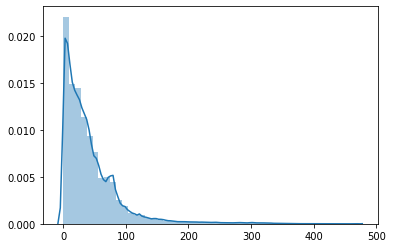

In [0]:
# Count maximum number of words per file.
wordDist = [len(w.split()) for w in A]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))
sns.distplot(wordDist)

In [0]:
# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 120493 unique tokens.


In [0]:
# Creates the training dataset, adding padding when necessary.
answer_data = pad_sequences(sequences, maxlen=90, 
                     padding = 'post') # add padding at the end. No difference in practice.

In [0]:
# Creates the objective function
labels = target
print('Shape of data tensor:', answer_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (328280, 90)
Shape of label tensor: (328280,)


In [0]:
# Create first matrix full with 0's
answer_embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        answer_embedding_matrix[i] = embedding_vector

# Print what came out
answer_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.040902  ,  0.058467  , -0.010321  , ...,  0.18736   ,
         0.00035375, -0.0033145 ],
       [ 0.0015377 ,  0.0092387 , -0.0097338 , ...,  0.10695   ,
        -0.016719  ,  0.002349  ],
       ...,
       [-0.028315  , -0.016291  , -0.053365  , ...,  0.05986   ,
         0.045068  ,  0.017336  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.019339  ,  0.014702  ,  0.0026496 , ...,  0.010836  ,
         0.023965  ,  0.0069051 ]])

#### question

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('/Users/andreasabia/Documents/ESCP/NLP/project/question.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)

In [0]:
# Create word index from input
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(Q)
sequences = tokenizer.texts_to_sequences(Q) # Create the sequences.
Vals = list(tokenizer.word_index.keys())

In [0]:
EmbeddingsDict = dict(zip(Vals, Embeddings.values))

Avg. no of words: 55.85
Std. deviation: 55.54
Max words: 456


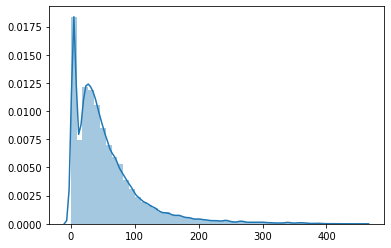

In [0]:
# Count maximum number of words per file.
wordDist = [len(w.split()) for w in Q]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))
sns.distplot(wordDist)

In [0]:
# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 105468 unique tokens.


In [0]:
# Creates the training dataset, adding padding when necessary.
question_data = pad_sequences(sequences, maxlen=90, 
                     padding = 'post') # add padding at the end. No difference in practice.

In [0]:
print('Shape of data tensor:', question_data.shape)

Shape of data tensor: (328280, 90)


In [0]:
# Create first matrix full with 0's
question_embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        question_embedding_matrix[i] = embedding_vector

# Print what came out
question_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.000767  , -0.036357  , -0.042976  , ...,  0.14262   ,
        -0.11275   , -0.065931  ],
       [-0.040902  ,  0.058467  , -0.010321  , ...,  0.18736   ,
         0.00035375, -0.0033145 ],
       ...,
       [-0.00022633, -0.044052  ,  0.057267  , ...,  0.07175   ,
         0.035076  , -0.040666  ],
       [ 0.099437  ,  0.04324   , -0.068357  , ...,  0.082004  ,
         0.088755  ,  0.0091962 ],
       [-0.059012  , -0.0070095 ,  0.030533  , ...,  0.044951  ,
        -0.069921  ,  0.00515   ]])

#### comment

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('/Users/andreasabia/Documents/ESCP/NLP/project/comment.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)

In [0]:
# Create word index from input
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(C)
sequences = tokenizer.texts_to_sequences(C) # Create the sequences.
Vals = list(tokenizer.word_index.keys())

In [0]:
EmbeddingsDict = dict(zip(Vals, Embeddings.values))

In [0]:
# Count maximum number of words per file.
wordDist = [len(w.split()) for w in C]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))

Avg. no of words: 10.18
Std. deviation: 57.89
Max words: 6723


In [0]:
# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 55896 unique tokens.


In [0]:
# Creates the training dataset, adding padding when necessary.
comment_data = pad_sequences(sequences, maxlen=90, 
                     padding = 'post') # add padding at the end. No difference in practice.

In [0]:
print('Shape of data tensor:', comment_data.shape)

Shape of data tensor: (328280, 90)


In [0]:
# Create first matrix full with 0's
comment_embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        comment_embedding_matrix[i] = embedding_vector

# Print what came out
comment_embedding_matrix

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [-6.1633e-02, -2.8373e-02, -2.7323e-02, ...,  8.9791e-02,
         3.1278e-02, -1.8085e-02],
       [-4.0902e-02,  5.8467e-02, -1.0321e-02, ...,  1.8736e-01,
         3.5375e-04, -3.3145e-03],
       ...,
       [ 1.8354e-05, -3.3405e-03, -2.7692e-02, ...,  3.7785e-02,
         6.9856e-02, -4.7577e-02],
       [ 1.7480e-03,  6.0647e-02, -4.2445e-02, ...,  4.4110e-03,
         6.2087e-02, -6.7328e-02],
       [-1.6274e-02,  5.0016e-02,  1.3052e-02, ..., -4.1031e-02,
        -7.7940e-02,  4.9011e-02]])

# MODELING

In [0]:
input_A=Input(shape=(90,))
input_Q=Input(shape=(90,))
input_C=Input(shape=(90,))

In [0]:
embedding_A=Embedding(len(answer_embedding_matrix), 300, weights=[answer_embedding_matrix],
                      input_length=90, trainable=False)(input_A)

embedding_Q=Embedding(len(question_embedding_matrix), 300, weights=[question_embedding_matrix],
                      input_length=90, trainable=False)(input_Q)

embedding_C=Embedding(len(comment_embedding_matrix), 300, weights=[comment_embedding_matrix],
                      input_length=90, trainable=False)(input_C)

input_combined=Concatenate()([embedding_A,embedding_Q,embedding_C])

In [0]:
first_output=LSTM(256)(input_combined)

In [0]:
input_n=Input(shape=(3,))
input_all=Concatenate()([first_output,input_n])

In [0]:
final_output=Dense(64, activation='relu')(input_all)
final_output=Dense(64, activation='relu')(final_output)
final_output=Dense(1, activation='sigmoid')(final_output)

In [0]:
model=Model(inputs=[input_A, input_Q, input_C, input_n], outputs=final_output)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 90, 300)      36148200    input_5[0][0]                    
____________________________________________________________________________________________

In [0]:
# Train test split
labels = labels.astype("int")
answer_train, answer_test, question_train, question_test, comment_train, comment_test, num_train, num_test, label_train, label_test =train_test_split(answer_data, 
                                                                       question_data,
                                                                       comment_data, O, labels,
                                                                       stratify=labels)

In [0]:
# Fit the model
history = model.fit([answer_train,question_train,comment_train,num_train], label_train, validation_split=0.33, epochs=1, batch_size=20)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

Train on 164960 samples, validate on 81250 samples
164960/164960 [==============================] - 3790s 23ms/sample - loss: 0.2337 - acc: 0.9294 - val_loss: 0.2151 - val_acc: 0.9296


In [0]:
from sklearn.metrics import roc_curve, auc
# Calculate outputs in test set
prob_test = model.predict([answer_test,question_test,comment_test,num_test], verbose = 1)
prob_train = model.predict([answer_train,question_train,comment_train,num_train], verbose = 1)

246210/246210 [==============================] - 1258s 5ms/sample


ValueError: Found input variables with inconsistent numbers of samples: [246210, 82070]

In [0]:
# Compute ROC curve and ROC area
fpr_train, tpr_train, _ = roc_curve(label_train, prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
print('\nAUC train: ', roc_auc_train)

# Compute ROC curve and ROC area
fpr_test, tpr_test, _ = roc_curve(label_test, prob_test)
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC test: ', roc_auc_test)


AUC train:  0.8013240087468211
AUC test:  0.8024963072992963


<Figure size 432x288 with 0 Axes>

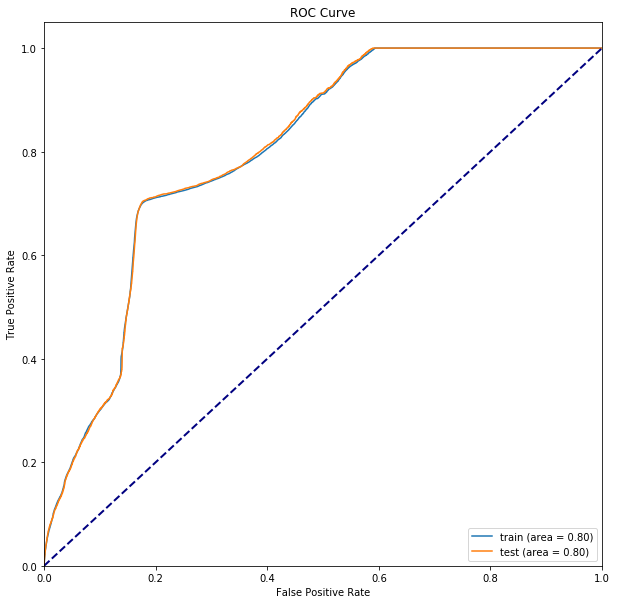

In [0]:
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr_train, tpr_train, label='train (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='test (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
# We can adjust the threshold (k) to choose between better recall or precision on the best answer prediction
adj=prob_test[:,0].tolist()
cut=[]
k=0.17
for i in range(len(adj)):
    if adj[i]>k:
        cut.append(1)
    else:
        cut.append(0)

print(classification_report(label_test,cut))
print(confusion_matrix(cut,label_test))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     76288
           1       0.27      0.12      0.16      5782

    accuracy                           0.92     82070
   macro avg       0.61      0.55      0.56     82070
weighted avg       0.89      0.92      0.90     82070

[[74488  5101]
 [ 1800   681]]
